In [1]:
!pip3 install beautifulsoup4 --user
!pip3 install metar --user
!pip3 install -q -U tqdm --user
!pip3 install -q -U https://github.com/matplotlib/basemap/archive/master.zip --user
!pip3 install portolan --user
!pip3 install pandas --user

  Using cached https://files.pythonhosted.org/packages/26/8c/1da0580f334718e04f8bbf74f0515a7fb8185ff96b2560ce080c11aa145b/pyproj-1.9.6.tar.gz
  Found existing installation: pyproj 2.6.1.post1
    Uninstalling pyproj-2.6.1.post1:
      Successfully uninstalled pyproj-2.6.1.post1
  Running setup.py install for pyproj ... done


In [1]:
import os
import re
import shutil
import datetime
import multiprocessing
from datetime import date, timedelta
from calendar import monthrange

from urllib.request import urlopen
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

from metar import Metar

import portolan

# Grids

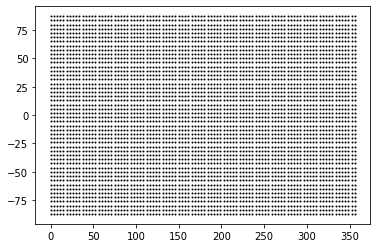

In [2]:
X_speedy_lon = np.linspace(0,360-3.75,96)
Y_speedy_lat = np.array("-87.159 -83.479 -79.777 -76.070 -72.362 -68.652 -64.942 -61.232 -57.521 -53.810 -50.099 -46.389 -42.678 -38.967 -35.256 -31.545 -27.833 -24.122 -20.411 -16.700 -12.989 -9.278 -5.567 -1.856 1.856 5.567 9.278 12.989 16.700 20.411 24.122 27.833 31.545 35.256 38.967 42.678 46.389 50.099 53.810 57.521 61.232 64.942 68.652 72.362 76.070 79.777 83.479 87.159".split(" "))
Y_speedy_lat = Y_speedy_lat.astype(np.float32)

def plot_speedy():
    plt.figure()
    for x in X_speedy_lon:
        for y in Y_speedy_lat:
            plt.plot(x,y,'ko',ms=1);

plot_speedy()

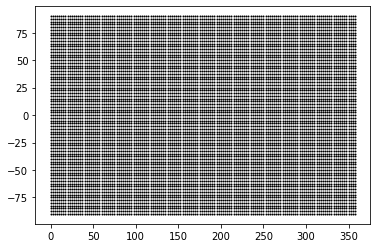

In [3]:
## NOAA latitude goes from North To South
X_noaa_lon = np.linspace(0,360-2.5,144)
Y_noaa_lat = np.linspace(90,-90,73)

def plot_noaa():
    plt.figure()
    for x in X_noaa_lon:
        for y in Y_noaa_lat:
            plt.plot(x,y,'ko',ms=1);

plot_noaa()

# Fetch observations

In [4]:
def fetch(url):
    try:
        html = urlopen(url).read()
        soup = BeautifulSoup(html, features='html.parser')
        for script in soup(["script", "style"]):
            script.extract()
        return soup
    except Exception:
        return None

def get_stations_noaa():
    soup = fetch('https://tgftp.nws.noaa.gov/data/observations/metar/stations/')
    stations = []
    for link in soup.find_all('a'):
        href = link.get('href')
        if 'TXT' in href:
            stations.append(href.split('.TXT')[0])
    return stations

def get_stations_with_coords():
    soup = fetch('http://weather.rap.ucar.edu/surface/stations.txt')
    text = soup.get_text()
    matches = re.findall(r".*([A-Z]{4}).*[\s]([\d]+\s[\d]+\w).*[\s]([\d]+\s[\d]+\w)[\s]*(\d{1,4}).*", text)
    stations = []
    for match in matches:
        stations.append({'ICAO': match[0], 'coords': "+".join(match[1:]).replace(' ', '-')})
    return stations

def gms_to_lat_lng(gms):
    comp = gms.split('-')
    if len(comp)==2:
        if 'N' in comp[1] or 'E' in comp[1]:
            return int(comp[0])+(int(comp[1][:len(comp)])/60)
        else:
            return -(int(comp[0])+(int(comp[1][:len(comp)])/60))
    elif len(comp)==3:
        if 'N' in comp[2] or 'E' in comp[2]:
            return int(comp[0])+(int(comp[1][:len(comp)])/60)+(int(comp[2][:len(comp)-1])/60)
        else:
            comp[2]='0'+comp[2][:len(comp)-1]
            return (-int(comp[0])-(int(comp[1][:len(comp)])/60)-(int(comp[2][:len(comp)-1])/3600))
    else:
        return 0

def get_all_metar_obs(station, month):
    now = datetime.datetime.utcnow()
    if month == now.month:
        url = f"https://www.ogimet.com/display_metars2.php?lang=en&lugar={station['ICAO']}&tipo=SA&ord=DIR&nil=NO&fmt=txt&ano={now.year}&mes={month}&day={now.day+1}&hora={now.hour}&min=00&anof=2020&mesf={month}&dayf={now.day}&horaf={now.hour}&minf=59"
    else:
        url = f"https://www.ogimet.com/display_metars2.php?lang=en&lugar={station['ICAO']}&tipo=SA&ord=DIR&nil=NO&fmt=txt&ano={now.year}&mes={month}&day=1&hora=00&min=00&anof=2020&mesf={month}&dayf={monthrange(now.year, month)[1]}&horaf=23&minf=59"
    soup = fetch(url)
    if soup is None:
        return []
    text = soup.get_text()
    if f"No hay METAR/SPECI de {station} en el periodo solicitado" in text:
        return []
    data = []
    text = re.sub('\s\s+', ' ', text)
    matches = re.findall(r"\s(\d+)[\s]METAR\s(.*)=", text)
    for match in matches:
        if ',' not in match:
            (lat, lng, elev) = station['coords'].split('+')
            data.append({ 'lat': gms_to_lat_lng(lat), 'lng': gms_to_lat_lng(lng), 'elev': elev, 'datetime': match[0], 'observation': match[1] })
    return data

# Parse data from METAR

In [5]:
PRESSURE_LEVELS_HEIGHTS_VALUES = [
    762,
    1458,
    3013,
    5576,
    9166,
    11787,
    16000,
]

def get_pressure(obs):
    """returns press Pa
    
    format examples:
        pressure: 1027.8 mb
        3-hr pressure change 1.7hPa, increasing, then decreasing
    """

    press = 0.0
    if 'pressure:' in obs:
        press = float(re.findall(r".*pressure:\s(.*)[\s]mb\s*", obs)[0])
    else:
        press = float(re.findall(r".*pressure[\s]change[\s](.*)hPa", obs)[0])

    return press * 100

def get_dew_point(obs):
    """ returns temp K """
    return float(re.findall(r".*dew[\s]point:\s(.*)[\s]C\s*", obs)[0]) + 273.15

def get_temperature(obs):
    """ returns temp K """
    return float(re.findall(r".*temperature:\s(.*)[\s]C\s*", obs)[0]) + 273.15

def nearest_neighbour(X_lng, Y_lat, lng, lat):
    diff_x = 100
    diff_y = 100
    pos_x = 0
    pos_y = 0
    for x in X_lng:
        diff = abs(x - lng)
        if diff_x > diff:
            pos_x = x
            diff_x = diff

    for y in Y_lat:
        diff = abs(y - lat)
        if diff_y > diff:
            pos_y = y
            diff_y = diff
    return (pos_x, pos_y)

def get_wind_comps(obs):
    # ESE at 11 knots
    # WSW at greater than 99 knots
    if 'knots' in obs and 'variable' not in obs:
        compass_point, mag = re.findall(r".*wind:\s(\w+)[\s|\w]*[\s]([0-9]+)[\s]knots", obs)[0]
        ang = portolan.middle(compass_point)
        # print(f"get_wind_comps, compass_point:{compass_point} mag:{mag}\n")
        mag = int(mag) / 1.944
        u = mag * np.sin(ang)
        v = mag * np.cos(ang)
        return (u, v)
    else:
        return (0, 0)

def elev_to_press_level(elev):
    max_diff = 10000
    level = 0
    for (idx, val) in enumerate(PRESSURE_LEVELS_HEIGHTS_VALUES):
        diff = abs(val - elev)
        if max_diff > diff:
            level = idx
            max_diff = diff
    return level

# Physical formulas

In [6]:
def vapor_pressure(T):
    """Return partial water vapor pressure (e) or saturation vapor pressure (es) hPa.
    
    dew_point for (e) K
    temperature for (es) K
    more info: https://cran.r-project.org/web/packages/humidity/vignettes/humidity-measures.html
    alternatives: August–Roche–Magnus formula
    """
    a = 17.2693882
    b = 35.86
    e = 6.1078 * np.exp(a * (T - 273.16) / (T - b))
    
    return e

def calculate_shum(dew_point, pressure):
    """Return specific humidity kg/kg.
    
    dew_point K
    pressure  Pa
    more info: https://cran.r-project.org/web/packages/humidity/vignettes/humidity-measures.html
    """
    e = vapor_pressure(dew_point)
    q = 0.622 * e  / (pressure - 0.378 * e)
    
    #print(dew_point, pressure, q)    
    return q

def calculate_rhum(dew_point, temp):
    """ validator: https://www.wpc.ncep.noaa.gov/html/dewrh.shtml """
    rhum = 100 * vapor_pressure(dew_point) / vapor_pressure(temp)

    #print(dew_point, temp, rhum)
    return rhum

In [7]:
noaa_stations = get_stations_with_coords()
print(len(noaa_stations))

9580


# Multiprocessing METARs fetching

In [9]:
months = [9 ,10, 11]

def get_metars_from_month_to_now(station):
    localdata = []
    for month in months:
        metar_obs = get_all_metar_obs(station, month)
        for obs_item in metar_obs:
            hour = datetime.datetime.strptime(obs_item['datetime'], '%Y%m%d%H%M').hour
            if hour == 0 or hour == 6 or hour == 12 or hour == 18:
                localdata.append([obs_item['lat'], obs_item['lng'], obs_item['elev'], obs_item['datetime'], obs_item['observation']])
        
    return localdata

In [10]:
jobs = multiprocessing.cpu_count()
with multiprocessing.Pool(jobs - 1) as p:
    data = p.map(get_metars_from_month_to_now, noaa_stations)

df = []
for elem in data:
    for arr in elem:
        df.append(arr)

len(df)

1689837

In [11]:
df = pd.DataFrame(data=df, columns=['lat', 'lng', 'elev', 'datetime', 'observation'])
df.head(5)

,lat,lng,elev,datetime,observation
0,51.883333,-176.65,4,202009010056,PADK 010056Z AUTO 26011G18KT 10SM FEW022 BKN03...
1,51.883333,-176.65,4,202009010656,PADK 010656Z AUTO 26010KT 10SM BKN055 OVC095 1...
2,51.883333,-176.65,4,202009011256,PADK 011256Z AUTO 24013KT 9SM OVC007 07/07 A30...
3,51.883333,-176.65,4,202009011856,PADK 011856Z AUTO 24015KT 8SM BKN006 OVC011 07...
4,51.883333,-176.65,4,202009020056,PADK 020056Z AUTO 25012G23KT 10SM BKN025 OVC03...


In [12]:
idx = 0
row = df.iloc[idx]
obs = Metar.Metar(row['observation']).string()
print(obs)
print(row['lat'], row['lng'], row['elev'])

station: PADK
type: routine report, cycle 1 (automatic report)
time: Sun Nov  1 00:56:00 2020
temperature: 13.3 C
dew point: 7.2 C
wind: W at 11 knots, gusting to 18 knots
visibility: 10 miles
pressure: 1018.3 mb
sky: a few clouds at 2200 feet
     broken clouds at 3600 feet
     broken clouds at 4400 feet
sea-level pressure: 1018.2 mb
remarks:
- Automated station (type 2)
METAR: PADK 010056Z AUTO 26011G18KT 10SM FEW022 BKN036 BKN044 13/07 A3007 RMK AO2 SLP182 T01330072
51.88333333333333 -176.65 4


In [13]:
df['datetime'] = pd.to_datetime(df.datetime)
df = df.sort_values(by='datetime')

df.head()

,lat,lng,elev,datetime,observation
1432007,4.833333,7.016667,18,2020-09-01,DNPO 010000Z 00000KT 6000 BKN007 23/22 Q1013 N...
932301,54.283333,-130.416667,34,2020-09-01,CYPR 010000Z AUTO 18003KT 120V210 3SM -RA BR O...
932555,49.466667,-120.516667,700,2020-09-01,CYDC 010000Z 35005KT 290V080 25SM FEW084 BKN09...
1648791,-25.183333,130.983333,496,2020-09-01,YAYE 010000Z AUTO 10005KT 9999 // NCD 20/03 Q1019
932675,53.016667,-122.516667,545,2020-09-01,CYQZ 010000Z AUTO 15008G17KT 9SM SCT050 OVC075...


In [14]:
def parse_metars(idx):
    dt = []
    cords = []
    row = df.iloc[idx]
    try:
        temp = 0.0
        obs = Metar.Metar(row['observation']).string()
        if ('temperature' in obs):
            temp = get_temperature(obs)
            if temp < 331.15:
                dt.append([row['datetime'].strftime("%Y-%m-%d %H:%M:%S"), row['lat'], row['lng'], row['elev'], 'air', temp])

        (u, v) = get_wind_comps(obs)
        if (u, v) != (0,0):
            dt.append([row['datetime'].strftime("%Y-%m-%d %H:%M:%S"), row['lat'], row['lng'], row['elev'], 'uwnd', u])
            dt.append([row['datetime'].strftime("%Y-%m-%d %H:%M:%S"), row['lat'], row['lng'], row['elev'], 'vwnd', v])

        if ('pressure' in obs):
            press = get_pressure(obs)
            if press < 105100 and press > 52200:
                dt.append([row['datetime'].strftime("%Y-%m-%d %H:%M:%S"), row['lat'], row['lng'], row['elev'], 'press', press])

        if ('dew point' in obs and 'pressure' in obs):
            dew_point = get_dew_point(obs)
            if dew_point > 0 and press < 105100 and press > 52200 and dew_point <= temp and temp != 0 :
                shum = calculate_shum(dew_point, press)
                rhum = calculate_rhum(dew_point, temp)
                dt.append([row['datetime'].strftime("%Y-%m-%d %H:%M:%S"), row['lat'], row['lng'], row['elev'], 'rhum', rhum])
                if shum < 0.05:
                    dt.append([row['datetime'].strftime("%Y-%m-%d %H:%M:%S"), row['lat'], row['lng'], row['elev'], 'shum', shum])

        cords.append((row['lat'], row['lng']))
    except Exception as e:
        str_err = str(e)
        if 'Unparsed groups' not in str_err and '_handleTime' not in str_err and '_handleWind' not in str_err and "NSW" not in str_err:
            print('index:', idx, 'error:', e)
    return (dt, cords)

In [15]:
jobs = multiprocessing.cpu_count()
with multiprocessing.Pool(jobs - 1) as p:
    data = p.map(parse_metars, range(len(df)))
    
df_parsed_metars = []
active_stations = []
for elem in data:
    df_parsed_metars += elem[0]
    for cords in elem[1]:
        if (cords not in active_stations):
            active_stations.append(cords)

print(f"total metars: {len(df_parsed_metars)}, active stations: {len(active_stations)}")

index: 647297 error: '--'
total metars: 9085793, active stations: 5169


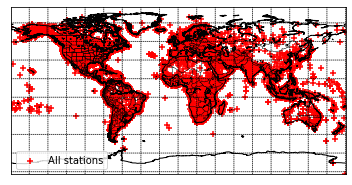

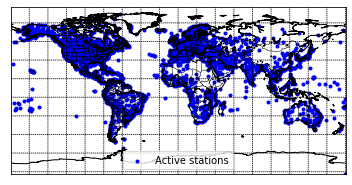

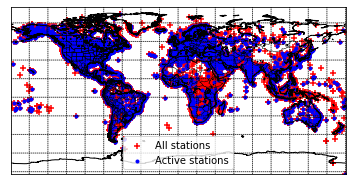

In [16]:
lati = []
lngt = []
lati2 = []
lngt2 = []
dataexport=[]
for station in noaa_stations:
    (lat, lng, elev) = station['coords'].split('+')
    lati.append(gms_to_lat_lng(lat))
    lngt.append(gms_to_lat_lng(lng))
    nombreEstacion=station['ICAO']
    dataexport.append([nombreEstacion,gms_to_lat_lng(lat),gms_to_lat_lng(lng),elev])

m = Basemap(resolution='l', lat_0=0, lon_0=0)
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.drawparallels(np.arange(-87.159, 87.159, 20))
m.drawmeridians(np.arange(0, 357.5, 20))
m.fillcontinents(color='white')
m.scatter(
    lngt,
    lati,
    marker='+',
    color='r',
    zorder=1.5,
    label='All stations',
    )
plt.legend()
plt.savefig('data/all_stations.jpg', dpi=600)
plt.show()

for station in active_stations:
    row = df.iloc[idx]
    lati2.append(station[0])
    lngt2.append(station[1])
    
m = Basemap(resolution='l', lat_0=0, lon_0=0)
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.drawparallels(np.arange(-87.159, 87.159, 20))
m.drawmeridians(np.arange(0, 357.5, 20))
m.fillcontinents(color='white')
m.scatter(
    lngt2,
    lati2,
    marker='.',
    color='b',
    zorder=1.5,
    label='Active stations',
    )
plt.legend()
plt.savefig('data/active_stations.jpg', dpi=600)
plt.show()

m = Basemap(resolution='l', lat_0=0, lon_0=0)
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.drawparallels(np.arange(-87.159, 87.159, 20))
m.drawmeridians(np.arange(0, 357.5, 20))
m.fillcontinents(color='white')
m.scatter(
    lngt,
    lati,
    marker='+',
    color='r',
    zorder=1.5,
    label='All stations',
    )
m.scatter(
    lngt2,
    lati2,
    marker='.',
    color='b',
    zorder=1.5,
    label='Active stations',
    )
plt.legend()
plt.savefig('data/all_stations_vs_active_stations.jpg', dpi=600)
plt.show()

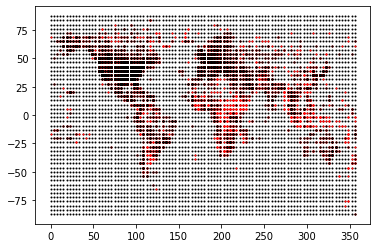

In [17]:
plot_speedy()
for station in noaa_stations:
    (lat, lng, elev) = station['coords'].split('+')
    (x, y) = nearest_neighbour(X_speedy_lon, Y_speedy_lat,
                               gms_to_lat_lng(lng) + 180,
                               gms_to_lat_lng(lat))
    plt.plot(x, y, 'ro', ms=1)

for cord in active_stations:
    (x, y) = nearest_neighbour(X_speedy_lon, Y_speedy_lat, cord[1]
                               + 180, cord[0])
    plt.plot(x, y, 'ko', ms=1)


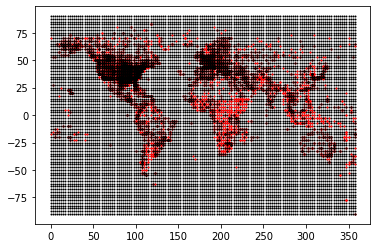

In [18]:
plot_noaa()
for station in noaa_stations:
    (lat, lng, elev) = station['coords'].split('+')
    (x, y) = nearest_neighbour(X_noaa_lon, Y_noaa_lat,
                               gms_to_lat_lng(lng) + 180,
                               gms_to_lat_lng(lat))
    plt.plot(x, y, 'ro', ms=1)

for cord in active_stations:
    (x, y) = nearest_neighbour(X_noaa_lon, Y_noaa_lat, cord[1]
                               + 180, cord[0])
    plt.plot(x, y, 'ko', ms=1)


In [19]:
df_metar_info = pd.DataFrame(df_parsed_metars,columns=['datetime','lat','lng','elev','variable','value'])

df_metar_info.head(10)

,datetime,lat,lng,elev,variable,value
0,2020-09-01 00:00:00,4.833333,7.016667,18,air,296.150000
1,2020-09-01 00:00:00,4.833333,7.016667,18,press,101300.000000
2,2020-09-01 00:00:00,4.833333,7.016667,18,rhum,94.108675
3,2020-09-01 00:00:00,4.833333,7.016667,18,shum,0.000162
4,2020-09-01 00:00:00,54.283333,-130.416667,34,air,287.150000
5,2020-09-01 00:00:00,54.283333,-130.416667,34,uwnd,-0.867965
6,2020-09-01 00:00:00,54.283333,-130.416667,34,vwnd,1.275983
7,2020-09-01 00:00:00,54.283333,-130.416667,34,press,101660.000000
8,2020-09-01 00:00:00,54.283333,-130.416667,34,rhum,100.000000
9,2020-09-01 00:00:00,54.283333,-130.416667,34,shum,0.000098


In [20]:
all_df_datetimes = []

for df_datetime in df_metar_info.datetime.unique():
    parsed_datetime = datetime.datetime.strptime(df_datetime, '%Y-%m-%d %H:%M:%S')
    if parsed_datetime.minute == 0:
        all_df_datetimes.append(parsed_datetime)

count    1.629425e+06
mean     8.743684e-05
std      4.807916e-05
min      4.166641e-08
25%      5.049711e-05
50%      7.609896e-05
75%      1.178573e-04
max      6.247101e-03
Name: value, dtype: float64

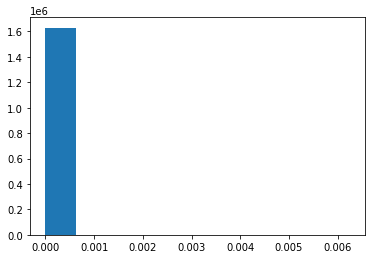

In [22]:
data = df_metar_info.loc[df_metar_info['variable']=='shum']['value']
plt.hist(data)
data.describe()

count    1.629425e+06
mean     7.112938e+01
std      2.346850e+01
min      1.611422e-02
25%      5.613871e+01
50%      7.680475e+01
75%      9.007311e+01
max      1.000000e+02
Name: value, dtype: float64

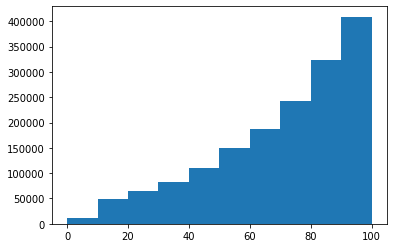

In [23]:
data = df_metar_info.loc[df_metar_info['variable']=='rhum']['value']
plt.hist(data)
data.describe()

count    1.644970e+06
mean     1.016149e+05
std      7.454783e+02
min      6.773000e+04
25%      1.012000e+05
50%      1.016600e+05
75%      1.021000e+05
max      1.049800e+05
Name: value, dtype: float64

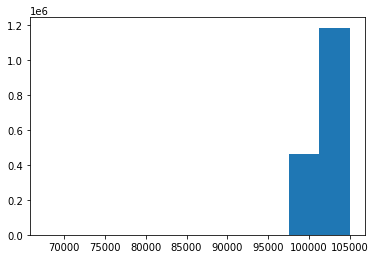

In [24]:
data = df_metar_info.loc[df_metar_info['variable']=='press']['value']
plt.hist(data)
data.describe()

count    1.642433e+06
mean     2.897757e+02
std      9.053015e+00
min      2.120500e+02
25%      2.837500e+02
50%      2.901500e+02
75%      2.966500e+02
max      3.251500e+02
Name: value, dtype: float64

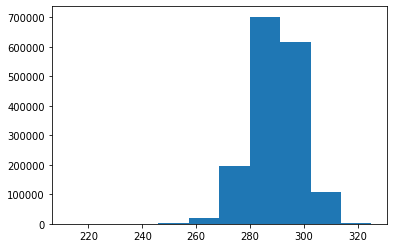

In [25]:
data = df_metar_info.loc[df_metar_info['variable']=='air']['value']
plt.hist(data)
data.describe()

count    1.269770e+06
mean    -1.805281e-01
std      3.111327e+00
min     -1.081283e+02
25%     -2.007475e+00
50%      0.000000e+00
75%      1.750830e+00
max      5.710645e+01
Name: value, dtype: float64

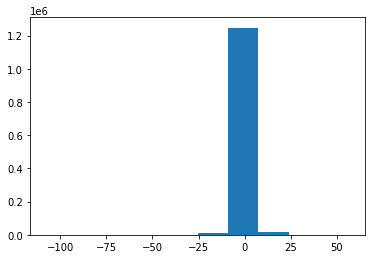

In [26]:
data = df_metar_info.loc[df_metar_info['variable']=='uwnd']['value']
plt.hist(data)
data.describe()

count    1.269770e+06
mean     2.152930e-01
std      3.473719e+00
min     -2.917995e+02
25%     -1.847099e+00
50%      2.042235e-01
75%      2.126639e+00
max      5.997942e+02
Name: value, dtype: float64

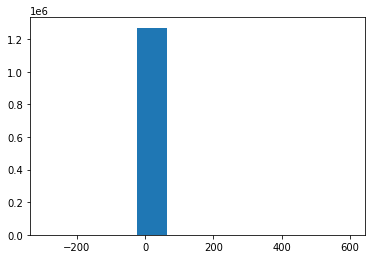

In [27]:
data = df_metar_info.loc[df_metar_info['variable']=='vwnd']['value']
plt.hist(data)
data.describe()

In [28]:
def create_csv(file_datetime):
    filename = "data/{}.csv".format(file_datetime.strftime('%Y%m%d%H'))
    df_file = df_metar_info.loc[df_metar_info['datetime'].str.contains(file_datetime.strftime('%Y-%m-%d %H'))]
    df_file.to_csv(filename, index=False)

In [29]:
path = os.path.abspath(os.getcwd())
shutil.rmtree(f"{path}/data")
os.mkdir(f"{path}/data")

In [30]:
jobs = multiprocessing.cpu_count()
with multiprocessing.Pool(jobs - 1) as p:
    data = p.map(create_csv, all_df_datetimes)